In [84]:
from load_results import load_result_dataset
import pandas as pd
import numpy as np
pn1 = 'full_fine_tuning_50epochs_edge_paper_final2'
pn2 = 'full_fine_tuning_50epochs_paper_final2'

final_data = load_result_dataset(pn1, pn2)
final_data = [{**d, 'ft_strategy': 'FFT (50 epochs)'} for d in final_data]

../results/full_fine_tuning_50epochs_paper_final2/CLIP-convnext_base_w-laion_aesthetic-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/CLIP-convnext_base_w-laion2B-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/deit_small_patch16_224.fb_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/robust_resnet50_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/vit_small_patch16_224.augreg_in21k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/convnext_base.fb_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/resnet50.a1_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/robust_vit_base_patch16_224_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_

In [85]:
import pandas as pd
import yaml

df = pd.DataFrame(final_data)
for arch_size in ('small', 'medium', 'large'):
    df_curr = df[ df.model_size == arch_size ]
    nan_percentage = (df_curr.isna().sum().sum() / df_curr.size) * 100
    print("Percentage of NaN values, for {} architecture: {}".format(arch_size, nan_percentage) )



Percentage of NaN values, for small architecture: 0.0700280112044818
Percentage of NaN values, for medium architecture: 0.0
Percentage of NaN values, for large architecture: 0.0


In [86]:
df = pd.DataFrame(final_data)

def get_restart_job(row):

    if row.isna().any():

        missing = {col: row[col] for col in ['clean_acc', 'Linf_acc', 'L1_acc', 'L2_acc', 'common_acc']}
        print(missing, missing.values(), all( list(missing.values()) ))

        if all(missing.values()):
            return "job1_hpo.sh"
        elif not missing['clean_acc'] and not missing['Linf_acc'] and missing['L1_acc']:
            return "job4_test_l1.sh"
        elif not missing['clean_acc'] and not missing['Linf_acc'] and not missing['L1_acc'] and missing['L2_acc']:
            return "job5_test_l2.sh"
        elif not missing['clean_acc'] and not missing['Linf_acc'] and not missing['L1_acc'] and not missing['L2_acc'] and missing['common_acc']:
            return "job6_test_common.sh"
    else:
        return None  # means no job needs to be restarted

df['restart_from'] = df.apply(get_restart_job, axis=1)
to_restart = df[df['restart_from'].notna()][['backbone', 'dataset', 'loss_function', 'restart_from', 'model_size']]
to_restart
# to_restart.to_csv("./restart_max.csv")

{'clean_acc': 0.912, 'Linf_acc': 0.763, 'L1_acc': 0.758, 'L2_acc': 0.821, 'common_acc': nan} dict_values([0.912, 0.763, 0.758, 0.821, nan]) True


,backbone,dataset,loss_function,restart_from,model_size
119,coat_tiny.in1k,caltech101,TRADES_v2,job1_hpo.sh,small


In [87]:
data = pd.DataFrame(final_data)
data.to_csv("fft50.csv")

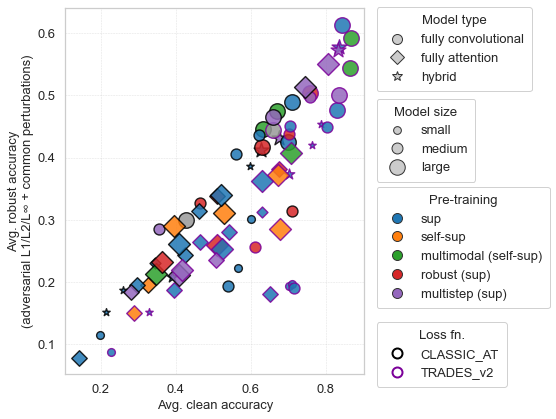

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math

import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15
})

pretty_color_labels = {
    'supervised': 'sup',
    'self-supervised': 'self-sup',
    'self-supervised (multimodal)': 'multimodal (self-sup)',
    'supervised (robust)': 'robust (sup)',
    'supervised (multistep)': 'multistep (sup)',
    'hybrid': 'hybrid'
}

# ── 1) Load ─────────────────────────────────────────────────────────────
data = pd.read_csv("fft50.csv")

# ── 2) Aggregate per configuration ──────────────────────────────────────
group_cols = ['backbone_name', 'loss_function', 'ft_strategy']
agg = (
    data.groupby(group_cols)
        .agg({
            'clean_acc': 'mean',
            'L1_acc': 'mean',
            'L2_acc': 'mean',
            'Linf_acc': 'mean',
            'common_acc': 'mean',
            'model_type': 'first',
            'model_size': 'first',
            'pre_training_strategy': 'first'
        })
        .reset_index()
)

# Normalise the strategy strings so they match the colour keys
agg['pre_training_strategy'] = (
    agg['pre_training_strategy']
        .astype(str).str.strip().str.lower()
)

# ── 3) Robust average ───────────────────────────────────────────────────
agg['robust_avg'] = agg[['L1_acc', 'L2_acc', 'Linf_acc', 'common_acc']].mean(axis=1)

# ── 4) Aesthetic mappings ───────────────────────────────────────────────
# marker_map = {'convolution': 'o', 'attention': 's', 'hybrid': '*'}
marker_map = {
    'fully convolutional'       : 'o',   # circle
    'fully attention': 'D',  # diamond
    'hybrid'    : '*'    # star
}

size_map   = {'small': 60, 'medium': 120, 'large': 240}

color_map = {
    'supervised'                    : '#1f77b4',
    'self-supervised'               : '#ff7f0e',
    'self-supervised (multimodal)'  : '#2ca02c',
    'supervised (robust)'           : '#d62728',
    'supervised (multistep)'        : '#9467bd'
}

edge_map = {
    'CLASSIC_AT': '#000000',   # solid black
    'TRADES_v2' : '#7B0099'    # vivid purple
}

# edge_map   = {'CLASSIC_AT': '#000000', 'TRADES_v2': '#8c564b'}

# ── 5) Scatter plot ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 6))
# fig, ax = plt.subplots(figsize=(2.2, 2.0))  # ~33% of \textwidth, compact


for _, row in agg.iterrows():
    ax.scatter(
        row['clean_acc'],
        row['robust_avg'],
        marker   = marker_map.get(row['model_type'], 'o'),
        s        = size_map.get(row['model_size'], 80),
        color    = color_map.get(row['pre_training_strategy'], '#999999'),
        edgecolor= edge_map.get(row['loss_function'], '#333333'),
        linewidth=1.4,
        alpha    = 0.85
    )

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_xlabel('Avg. clean accuracy')
ax.set_ylabel('Avg. robust accuracy\n(adversarial L1/L2/L∞ + common perturbations)')

# Leave space on the right for the stacked legends
plt.tight_layout(rect=[0, 0, 0.78, 1])

# ── 6) Four non‑overlapping legends ─────────────────────────────────────
legend_kw = dict(frameon=True, framealpha=0.9, borderpad=0.6, fontsize=13)

#      (x,  y) are fractions of the axes bounding box (right side)
first  = ax.legend(
    [Line2D([0], [0], marker=m, color='w', markerfacecolor='#cccccc',
            markeredgecolor='#333333', markersize=10) for m in marker_map.values()],
    marker_map.keys(), title='Model type',
    loc='upper left', bbox_to_anchor=(1.02, 1.02), **legend_kw)

second = ax.legend(
    [Line2D([0], [0], marker='o', color='w', markerfacecolor='#cccccc',
            markeredgecolor='#333333', markersize=math.sqrt(v))
     for v in size_map.values()],
    size_map.keys(), title='Model size',
    loc='upper left', bbox_to_anchor=(1.02, 0.77), **legend_kw)

third  = ax.legend(
    [Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
            markeredgecolor='#333333', markersize=10)
     for c in color_map.values()],
    [pretty_color_labels[k] for k in color_map.keys()], title='Pre-training',
    loc='upper left', bbox_to_anchor=(1.02, 0.53), **legend_kw)

fourth = ax.legend(
    [Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffffff',
            markeredgecolor=c, markeredgewidth=2.0, markersize=10)
     for c in edge_map.values()],
    edge_map.keys(), title='Loss fn.',
    loc='upper left', bbox_to_anchor=(1.02, 0.16), **legend_kw)

# Add the legends back to the axes so they all show up
ax.add_artist(first)
ax.add_artist(second)
ax.add_artist(third)
# fourth added last automatically by ax.legend() call

# ── 7) Save & show ──────────────────────────────────────────────────────
# plot_path = './paper_figures/clean_vs_robust_scatter_enhanced.png'
# plt.savefig(plot_path, dpi=300)
# plt.show()
plot_path = './paper_figures/clean_vs_robust_scatter_enhanced_tight.png'
plt.savefig(plot_path, dpi=400, bbox_inches='tight', pad_inches=0.02)
plt.show()


In [91]:
from process_database import process_grouped_df, process_rankings, compute_odds_ratio_by_group

size = "small" #"small"
grouped_df = process_grouped_df(final_data,   )
grouped_df = process_rankings(grouped_df)
grouped_df = grouped_df[ ('TOTAL', )].reset_index()
# grouped_df.sort_values(by="sum", ascending=False)
# grouped_df.to_csv("./fft50.csv")
# grouped_df

Percentage of NaN values: 0.01%


In [ ]:
grouped_df = process_grouped_df(final_data,   )
grouped_df = process_rankings(grouped_df)
grouped_df = grouped_df[ ('TOTAL', )].reset_index()

# Filter for large architectures
large_models = grouped_df[ (grouped_df['model_size'] == 'medium') & (grouped_df['pre_training_strategy'] == 'supervised (robust)') ]
medium1 = large_models['borda'].mean()
large_models = grouped_df[ (grouped_df['model_size'] == 'large') & (grouped_df['pre_training_strategy'] == 'supervised (robust)') ]
large1 = large_models['borda'].mean()
rate_a = (large1 - medium1) / medium1
rate_b = (large1 - medium1) / ((large1 + medium1) / 2)
print(rate_a, rate_b)


large_models = grouped_df[ (grouped_df['model_size'] == 'medium') & (grouped_df['pre_training_strategy'] == 'supervised (multistep)') ]
medium2 = large_models['borda'].mean()
large_models = grouped_df[ (grouped_df['model_size'] == 'large') & (grouped_df['pre_training_strategy'] == 'supervised (multistep)') ]
large2 = large_models['borda'].mean()
rate_a = (large2 - medium2) / medium2
rate_b = (large2 - medium2) / ((large2 + medium2) / 2)
print(rate_a, rate_b)


# large_models = grouped_df[ (grouped_df['model_size'] == 'medium') & (grouped_df['pre_training_strategy'] == 'supervised (multistep)') ]
# mean_score_large = large_models['borda'].mean()
# print(mean_score_large)

# large_models = grouped_df[ (grouped_df['model_size'] == 'medium') & (grouped_df['pre_training_strategy'] == 'supervised') ]
# mean_score_large = large_models['borda'].mean()
# print(mean_score_large)

# large_models = grouped_df[ (grouped_df['model_size'] == 'medium') & (grouped_df['pre_training_strategy'] == 'self-supervised') ]
# mean_score_large = large_models['borda'].mean()
# print(mean_score_large)

# large_models = grouped_df[ (grouped_df['model_size'] == 'medium') & (grouped_df['pre_training_strategy'] == 'supervised (multistep)') ]
# mean_score_large = large_models['borda'].mean()
# print(mean_score_large)

0.12917375932957975 0.12133698225761823
0.5642112914950327 0.440066146940704


In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

process = grouped_df[("TOTAL",)] 
process = process.reset_index()

process.to_csv("fft50_anova.csv")

# # Run ANOVA
# model = smf.ols('borda ~ C(model_size) + C(model_type) + C(loss_function) + C(pre_training_strategy)', data=process).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)

# model = smf.ols('borda ~ C(model_size)/C(model_type)', data=process).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)

# model = smf.ols('borda ~ C(model_size)/C(pre_training_strategy)', data=process).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)

# model = smf.ols('borda ~ C(model_size)/C(loss_function)', data=process).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)

# model = smf.ols('borda ~ C(model_type)/C(pre_training_strategy)', data=process).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)

# model = smf.ols('borda ~ C(loss_function)/C(pre_training_strategy)', data=process).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)


model_size


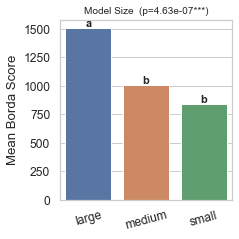

model_type


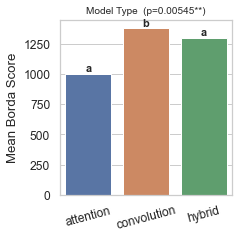

loss_function


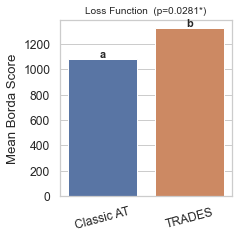

pre_training_strategy


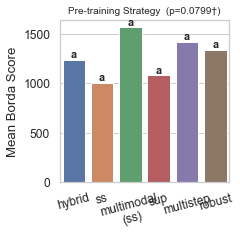

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
from statsmodels.stats.multicomp import MultiComparison
import inspect

# Load the dataset again after reset
# df = pd.read_csv("/mnt/data/fft50_anova.csv")

# Helper functions
xtick_label_map = {
    "hybrid": "hybrid",
    "self-supervised": "ss",
    "self-supervised (multimodal)": "multimodal\n(ss)",
    "supervised": "sup",
    "supervised (robust)": "robust",
    "supervised (multistep)": "multistep",
    "fully attention": "attention",
    "fully convolutional": "convolution",
    "CLASSIC_AT": "Classic AT",
    "TRADES_v2": "TRADES",
}

def anova_stars(p):
    return '***' if p < 1e-3 else '**' if p < 1e-2 else '*' if p < .05 else '†' if p < .1 else ''

def get_tukey_letters(df, group_col, value_col, alpha=0.05):
    mc   = MultiComparison(df[value_col], df[group_col])
    res  = mc.tukeyhsd(alpha=alpha)
    comp = pd.DataFrame(res.summary().data[1:], columns=res.summary().data[0])
    comp['reject'] = comp['reject'].astype(bool)

    groups   = list(mc.groupsunique)
    letters  = {g: '' for g in groups}
    remaining = set(groups)
    current   = 'a'

    while remaining:
        anchor  = sorted(remaining)[0]
        cluster = {anchor}
        for g in sorted(remaining):
            sig = comp.loc[
                ((comp.group1 == g) & (comp.group2.isin(cluster))) |
                ((comp.group2 == g) & (comp.group1.isin(cluster))), 'reject'
            ].any()
            if not sig:
                cluster.add(g)
        for g in cluster:
            letters[g] += current
        remaining -= cluster
        current = chr(ord(current) + 1)
    return letters

# Compute Welch's ANOVA p-values
welch_pvals = {}
for factor in ['model_size', 'model_type', 'loss_function', 'pre_training_strategy']: 
    df_filtered = process[[factor, 'borda']].dropna()
    groups = [group['borda'].values for name, group in df_filtered.groupby(factor)]
    _, pval = stats.f_oneway(*groups)
    welch_pvals[factor] = pval

# Plot configuration
sns.set(style="whitegrid", font_scale=1.1)
save_dir = "paper_figures"
os.makedirs(save_dir, exist_ok=True)
single_figsize = (3.2, 3.2)

titles = {
    'model_size': 'Model Size',
    'model_type': 'Model Type',
    'loss_function': 'Loss Function',
    'pre_training_strategy': 'Pre-training Strategy'
}

# Plot for each factor using Welch's ANOVA p-value
for factor in titles:
    print(factor)

    order = sorted(process[factor].dropna().unique())
    letters = get_tukey_letters(process, factor, 'borda', alpha=0.1)

    fig, ax = plt.subplots(figsize=single_figsize)

    kwargs = dict(
        x=factor, y='borda', data=process, order=order,
        estimator=np.mean, ci=None, ax=ax
    )
    if 'errorbar' in inspect.signature(sns.barplot).parameters:
        kwargs['errorbar'] = None
    sns.barplot(**kwargs)

    ax.set_ylabel("Mean Borda Score")
    ax.set_xlabel("")

    ax.tick_params(axis='x',  rotation=15)
    
    if set(order).issubset(xtick_label_map.keys()):
        ax.set_xticklabels([xtick_label_map[l] for l in order])

    for bar, lvl in zip(ax.containers[0], order):
        ltr = letters.get(lvl, '')
        if ltr:
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.01,
                    ltr, ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

    # Use Welch's p-value
    p = welch_pvals[factor]
    ax.set_title(f"{titles[factor]}  (p={p:.3g}{anova_stars(p)})", fontsize=10)

    fname = f"{save_dir}/main_effect_{factor}.png"
    plt.tight_layout(pad=0.2)
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    # plt.close(fig)
    plt.show()


In [178]:
process

metric,backbone,backbone_name,loss_function,pre_training_strategy,model_type,model_size,ft_strategy,borda,nan_geom_cnt,nan_sum_cnt,rank_borda,rank_geom,rank_sum,score_geom,score_sum
0,convnext_base.fb_in22k,"convnext_b,sup,in22k",TRADES_v2,supervised,fully convolutional,large,FFT (50 epochs),2280.0,0,0,1.0,1.0,1.0,1.320645,19.789302
1,CLIP-convnext_base_w-laion2B-s13B-b82K,"convnext_b,clip,laion2b",TRADES_v2,self-supervised (multimodal),fully convolutional,large,FFT (50 epochs),2066.0,0,0,4.0,6.0,2.0,1.001878,19.396968
2,coatnet_2_rw_224.sw_in12k,"coatnet_2,sup,in12k",TRADES_v2,supervised,hybrid,large,FFT (50 epochs),2115.0,0,0,3.0,3.0,3.0,1.085487,18.874429
3,coatnet_2_rw_224.sw_in12k_ft_in1k,"coatnet_2,sup,in12k-in1k",TRADES_v2,supervised,hybrid,large,FFT (50 epochs),2126.0,0,0,2.0,2.0,4.0,1.147118,18.743905
4,CLIP-convnext_base_w-laion_aesthetic-s13B-b82K,"convnext_b,clip,laiona",TRADES_v2,self-supervised (multimodal),fully convolutional,large,FFT (50 epochs),1991.0,0,0,7.0,21.0,5.0,0.651343,18.235889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,vit_small_patch16_224.dino,"vit_b,dino,in1k",TRADES_v2,self-supervised,fully attention,medium,FFT (50 epochs),367.0,0,0,79.0,67.0,76.0,0.062691,5.332063
76,mobilevit-small,"mobilevit_s,sup,in1k",CLASSIC_AT,supervised,hybrid,small,FFT (50 epochs),610.0,0,0,74.0,73.0,77.0,0.035784,4.924286
77,efficientnet-b0,"efficientnet_b0,sup,in1k",CLASSIC_AT,supervised,fully convolutional,small,FFT (50 epochs),423.0,0,0,78.0,77.0,78.0,0.012939,3.946429
78,efficientnet-b0,"efficientnet_b0,sup,in1k",TRADES_v2,supervised,fully convolutional,small,FFT (50 epochs),329.0,0,0,80.0,79.0,79.0,0.002835,3.465190


In [181]:
# Relevant variable pairs for interaction
interaction_pairs = [ 
                    # "model_size",
                    #   "model_type", 
                    # "loss_function",
                    #  "model_type", 
                    "pre_training_strategy",
                        ]

# Container to store results
results = {}

for var1 in interaction_pairs:
    formula = f"borda ~ C({var1})"
    model = smf.ols(formula, data=process).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Compute group means for plotting
    group_means = process.groupby([var1,])["borda"].mean().reset_index()

    # Store in results dictionary
    key = f"{var1}"
    results[key] = {
        "anova": anova_table,
        "means": group_means,
    }

results


{'pre_training_strategy': {'anova':                                 sum_sq    df         F    PR(>F)
  C(pre_training_strategy)  1.393828e+06   4.0  1.393903  0.244258
  Residual                  1.874899e+07  75.0       NaN       NaN,
  'means':           pre_training_strategy        borda
  0                        hybrid  1241.250000
  1               self-supervised  1006.625000
  2  self-supervised (multimodal)  1566.166667
  3                    supervised  1158.096154
  4           supervised (robust)  1338.600000}}

In [39]:
# Relevant variable pairs for interaction
interaction_pairs = [
    ("model_size", "model_type"),
    ("loss_function", "model_type"),
    ("loss_function", "model_size"),
    ("pre_training_strategy", "model_type"),
    ("pre_training_strategy", "model_size"),
    ("pre_training_strategy", "loss_function"),
]

# Container to store results
results = {}

for var1, var2 in interaction_pairs:
    print(var1, var2)
    formula = f"borda ~ C({var1}) / C({var2})"
    model = smf.ols(formula, data=process).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Compute group means for plotting
    group_means = process.groupby([var1, var2])["borda"].mean().reset_index()

    # Store in results dictionary
    key = f"{var1}/{var2}"
    results[key] = {
        "anova": anova_table,
        "means": group_means,
    }

results


model_size model_type
loss_function model_type
loss_function model_size
pre_training_strategy model_type
pre_training_strategy model_size
pre_training_strategy loss_function


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 7
  warnings.warn('covariance of constraints does not have full '
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints

{'model_size/model_type': {'anova':                                    sum_sq    df          F        PR(>F)
  C(model_size)                6.351995e+06   2.0  25.954003  3.463980e-09
  C(model_size):C(model_type)  5.102537e+06   6.0   6.949589  7.741320e-06
  Residual                     8.688286e+06  71.0        NaN           NaN,
  'means':   model_size           model_type        borda
  0      large      fully attention  1210.000000
  1      large  fully convolutional  1796.571429
  2      large               hybrid  1811.750000
  3     medium      fully attention   800.437500
  4     medium  fully convolutional  1267.500000
  5     medium               hybrid  1066.500000
  6      small      fully attention   799.500000
  7      small  fully convolutional   644.833333
  8      small               hybrid  1037.500000},
 'loss_function/model_type': {'anova':                                       sum_sq    df         F    PR(>F)
  C(loss_function)                1.214752e+06   1.0  

In [161]:
results['pre_training_strategy/model_size']['means']

,pre_training_strategy,model_size,borda
0,hybrid,large,1241.250000
1,self-supervised,large,1411.000000
2,self-supervised,medium,602.250000
3,self-supervised (multimodal),large,1566.166667
4,supervised,large,1579.111111
5,supervised,medium,1005.200000
6,supervised,small,835.214286
7,supervised (robust),large,1437.250000
8,supervised (robust),medium,1272.833333


In [40]:
import pandas as pd
import scipy.stats as stats

# Define interaction pairs
interaction_pairs = [
    ("model_size", "model_type"),
    ("loss_function", "model_type"),
    ("loss_function", "model_size"),
    ("loss_function", "pre_training_strategy"),
    ("pre_training_strategy", "model_type"),
    ("pre_training_strategy", "model_size"), 
]

# Container for results
results = {}

for var1, var2 in interaction_pairs:
    print(f"{var1} / {var2}")
    df_filtered = process[[var1, var2, 'borda']].dropna().copy()
    df_filtered['interaction'] = df_filtered[var1].astype(str) + ' | ' + df_filtered[var2].astype(str)

    # Compute group means
    group_means = df_filtered.groupby([var1, var2])['borda'].mean().reset_index()

    # Group data by interaction label
    interaction_groups = [group['borda'].values for _, group in df_filtered.groupby('interaction')]

    # Welch-style ANOVA (technically still f_oneway, but applied to heteroscedastic groups)
    try:
        f_stat, p_val = stats.f_oneway(*interaction_groups)
    except Exception:
        f_stat, p_val = float('nan'), float('nan')

    # Mock anova table with similar structure
    anova_table = pd.DataFrame({
        'sum_sq': [None],
        'df': [len(interaction_groups) - 1],
        'F': [f_stat],
        'PR(>F)': [p_val]
    }, index=[f'C({var1}):C({var2})'])

    # Store results
    key = f"{var1}/{var2}"
    results[key] = {
        "anova": anova_table,
        "means": group_means,
    }


model_size / model_type
loss_function / model_type
loss_function / model_size
loss_function / pre_training_strategy
pre_training_strategy / model_type
pre_training_strategy / model_size


model_size model_type
1.8681560501608005e-10


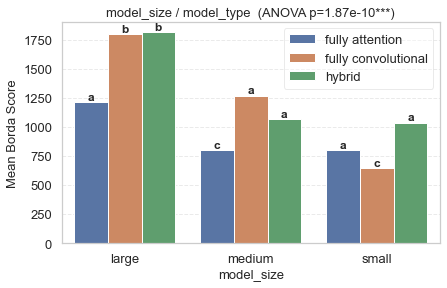

loss_function model_type
0.006582852663508255


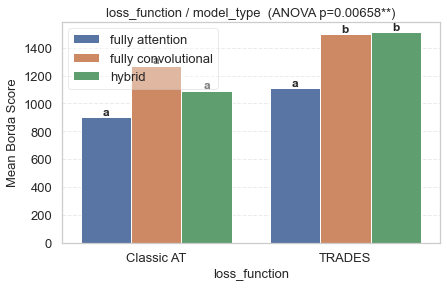

loss_function model_size
5.58747209321879e-07


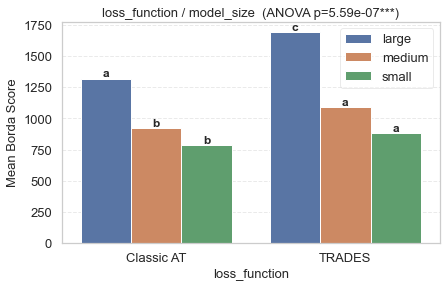

loss_function pre_training_strategy
0.11653175706870803


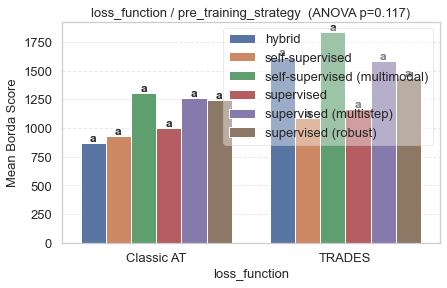

pre_training_strategy model_type
0.03834021703099238


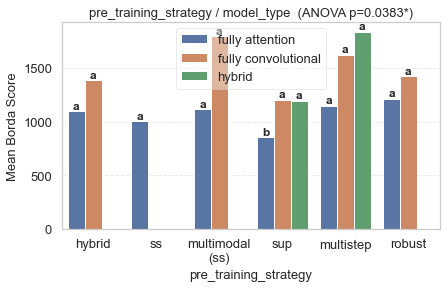

pre_training_strategy model_size
7.564431751914254e-05


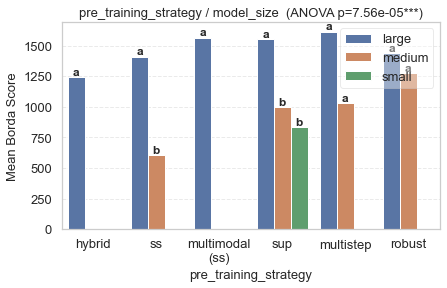

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
import pandas as pd

# Custom label mapping (applies only when var1 is one of these)
# Custom label mapping (applies only when var1 is one of these)
xtick_label_map = {
    "hybrid": "hybrid",
    "self-supervised": "ss",
    "self-supervised (multimodal)": "multimodal\n(ss)",
    "supervised": "sup",
    "supervised (robust)": "robust",
    "supervised (multistep)": "multistep",
    "fully attention": "attention",
    "fully convolutional": "convolution",
    "CLASSIC_AT": "Classic AT",
    "TRADES_v2": "TRADES",
}


# ── helpers ──────────────────────────────────────────────────────────────
def anova_stars(p):
    return '***' if p < 1e-3 else '**' if p < 1e-2 else '*' if p < .05 else '†' if p < .1 else ''

from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 13,             # base size for all text
    'axes.titlesize': 13,        # title
    'axes.labelsize': 13,        # axis labels
    'xtick.labelsize': 13,       # x-tick labels
    'ytick.labelsize': 13,       # y-tick labels
    'legend.fontsize': 13,       # legend
})


def get_tukey_letters(df, group_col, value_col, alpha=0.1):
    """
    Return dict {group_label: letter(s)} using Tukey HSD results.
    Same letter → groups NOT significantly different (α).
    """
    mc      = MultiComparison(df[value_col], df[group_col])
    result  = mc.tukeyhsd(alpha=alpha)

    # Convert summary to DataFrame
    comp = pd.DataFrame(result.summary().data[1:], columns=result.summary().data[0])
    comp['reject'] = comp['reject'].astype(bool)   # ensure Boolean

    groups = list(mc.groupsunique)
    letters = {g: '' for g in groups}
    current_letter = 'a'

    # Greedy algorithm to assign letters
    remaining = set(groups)
    while remaining:
        # Start a new group with the first remaining item
        g0 = sorted(remaining)[0]
        group_set = {g0}

        # Add any non‑significant partners to this letter group
        for g in sorted(remaining):
            # Is there any significant diff between g and something already in group_set?
            sig_any = comp.loc[
                ((comp['group1'] == g) & (comp['group2'].isin(group_set))) |
                ((comp['group2'] == g) & (comp['group1'].isin(group_set))), 'reject'
            ].any()
            if not sig_any:
                group_set.add(g)

        # assign current letter to everyone in this cluster
        for g in group_set:
            letters[g] += current_letter
        remaining -= group_set
        current_letter = chr(ord(current_letter) + 1)

    return letters


import matplotlib.pyplot as plt
import seaborn as sns

for key, res in results.items():
    if 'anova' not in res or 'means' not in res or '/' not in key:
        continue

    var1, var2   = key.split('/')
    df_means     = res['means'].copy()
    df_full      = process.copy()

    print(var1, var2)

    # build orders
    x_order   = sorted(df_means[var1].unique())
    hue_order = sorted(df_means[var2].unique())

    # interaction labels
    df_full['interaction']  = df_full[var1].astype(str) + ' | ' + df_full[var2].astype(str)
    df_means['interaction'] = df_means[var1].astype(str) + ' | ' + df_means[var2].astype(str)

    # Tukey letters
    letters = get_tukey_letters(df_full, 'interaction', 'borda', alpha=0.1)
    df_means['letter'] = df_means['interaction'].map(letters)

    # ANOVA p‑value
    int_label = f'C({var1}):C({var2})'
    anova_p   = res['anova'].loc[int_label if int_label in res['anova'].index
                                 else res['anova'].index[-1], 'PR(>F)']
    
    print(anova_p)

    # plot
    # plt.figure(figsize=(10, 6))
    plt.figure(figsize=(6.4, 4.2))  # clean, LaTeX-optimized

    ax = sns.barplot(data=df_means,
                     x=var1, y='borda', hue=var2,
                     order=x_order, hue_order=hue_order)
    
    if set(x_order).issubset(xtick_label_map.keys()):
        new_labels = [xtick_label_map.get(l, l) for l in x_order]
        ax.set_xticklabels(new_labels)

    # annotate letters
    for c_idx, container in enumerate(ax.containers):
        hue_val = hue_order[c_idx]
        for b_idx, bar in enumerate(container):
            x_val  = x_order[b_idx]
            key_lbl = f"{x_val} | {hue_val}"
            letter  = letters.get(key_lbl, '')
            if letter:
                ax.text(bar.get_x() + bar.get_width()/2.,
                        bar.get_height() + 0.01,
                        letter, ha='center', va='bottom',
                        fontsize=12, fontweight='bold')

    plt.title(f"{var1} / {var2}  "
              f"(ANOVA p={anova_p:.3g}{anova_stars(anova_p)})")
    plt.ylabel("Mean Borda Score")

    # plt.xticks(rotation=45)
    plt.xticks(rotation=0)

    plt.grid(axis='y', linestyle='--', alpha=.4)
    plt.tight_layout()
    plt.legend(frameon=True, framealpha=0.4)  # lower alpha → more transparency

    plt.savefig(
        f"paper_figures/interaction_{key.replace('/', '_')}.png",  # or .pdf, .svg, etc.
        dpi=300,          # high resolution
        bbox_inches='tight',  # remove extra whitespace
        pad_inches=0.05,       # minimal border around axes
        transparent=False      # or True if you want alpha background
    )

    plt.show()

In [83]:
# grouped_df[('caltech101',)].head(50)
# grouped_df[  ('caltech101', )  ]

grouped_df[ ('caltech101', 'target_rank') ] =  grouped_df[('caltech101', 'borda')].rank(ascending=False, method='min')

extraction = grouped_df[ grouped_df[ ('caltech101', 'target_rank') ] == 1 ]
extraction

dataset                                                                                                                                        TOTAL  \
metric                                                                                                                                         borda   
backbone                       backbone_name             loss_function pre_training_strategy  model_type          model_size ft_strategy               
convnext_base.fb_in22k_ft_in1k convnext_b,sup,in22k-in1k TRADES_v2     supervised (multistep) fully convolutional large      FFT (50 epochs)  2000.0   

dataset                                                                                                                                                    \
metric                                                                                                                                       nan_geom_cnt   
backbone                       backbone_name             loss_function pre_training_strategy  model_type          model_size ft_strategy                    
convnext_base.fb_in22k_ft_in1k convnext_b,sup,in22k-in1k TRADES_v2     supervised (multistep) fully convolutional large      FFT (50 epochs)            0   

dataset                                                                                                                                                   \
metric                                                                                                                                       nan_sum_cnt   
backbone                       backbone_name             loss_function pre_training_strategy  model_type          model_size ft_strategy                   
convnext_base.fb_in22k_ft_in1k convnext_b,sup,in22k-in1k TRADES_v2     supervised (multistep) fully convolutional large      FFT (50 epochs)           0   

dataset                                                                                                                                                  \
metric                                                                                                                                       rank_borda   
backbone                       backbone_name             loss_function pre_training_strategy  model_type          model_size ft_strategy                  
convnext_base.fb_in22k_ft_in1k convnext_b,sup,in22k-in1k TRADES_v2     supervised (multistep) fully convolutional large      FFT (50 epochs)        5.0   

dataset                                                                                                                                                 \
metric                                                                                                                                       rank_geom   
backbone                       backbone_name             loss_function pre_training_strategy  model_type          model_size ft_strategy                 
convnext_base.fb_in22k_ft_in1k convnext_b,sup,in22k-in1k TRADES_v2     supervised (multistep) fully convolutional large      FFT (50 epochs)      12.0   

dataset                                                                                                                                                \
metric                                                                                                                                       rank_sum   
backbone                       backbone_name             loss_function pre_training_strategy  model_type          model_size ft_strategy                
convnext_base.fb_in22k_ft_in1k convnext_b,sup,in22k-in1k TRADES_v2     supervised (multistep) fully convolutional large      FFT (50 epochs)      8.0   

dataset                                                                                                                                                  \
metric                                                                                                                             

In [78]:
import matplotlib.pyplot as plt

# Rebuild radar data with config names included for each dataset's rank-1 configuration
radar_data_with_names = []

datas= [ 'stanford_cars',
        'oxford-iiit-pet',
        'caltech101' ,
        'flowers-102' ,
        'fgvc-aircraft-2013b',
        'uc-merced-land-use-dataset' ]

target = 'borda'
results = []
for dataset in sorted(datas):

        grouped_df[ (dataset, 'target_rank') ] =  grouped_df[(dataset, target)].rank(ascending=False, method='min')
        extraction = grouped_df[ grouped_df[ (dataset, 'target_rank') ] == 1 ]
        idx = pd.IndexSlice
        extr = extraction.loc[:, idx[dataset, ['L1_acc', 'L2_acc', 'Linf_acc', 'clean_acc', 'common_acc' ]]]
        metric_dict = {metric: float(extr[(dataset, metric)]) for metric in ['L1_acc', 'L2_acc', 'Linf_acc', 'clean_acc', 'common_acc']}
        metric_dict['backbone_name'] = extraction.index.get_level_values('backbone_name')[0]
        metric_dict['loss_function'] = extraction.index.get_level_values('loss_function')[0]
        metric_dict['dataset'] = dataset
        results.append( metric_dict )

results = pd.DataFrame(results)

import plotly.graph_objects as go
import plotly.colors as pc
import numpy as np
import pandas as pd

# Define axis labels
categories = ['L1_acc', 'L2_acc', 'Linf_acc', 'common_acc', 'clean_acc']
symbol_labels = [r'T(1)', r'T(2)', r'T(∞)', r'T(common)', r'T(∅)']

# Compute area as sum of metrics (proxy for polygon area)
results['area'] = results[categories].sum(axis=1)
results_sorted = results.sort_values(by='area', ascending=False).reset_index(drop=True)

# Use Plotly's qualitative color set
colors = pc.qualitative.Set2

fig = go.Figure()

for i, (_, row) in enumerate(results_sorted.iterrows()):
    lbl = f"{row['dataset']}<br>{row['backbone_name']}<br>{row['loss_function']}"
    values = [row[metric] for metric in categories]
    values += [values[0]]  # Close shape

    color = colors[i % len(colors)]

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=symbol_labels + [symbol_labels[0]],
        fill='toself',
        name=lbl,
        fillcolor=color.replace('rgb', 'rgba').replace(')', ', 0.3)'),  # 30% fill opacity
        line=dict(color=color, width=4.5)  # Increased line thickness and full opacity
    ))

# Layout
fig.update_layout(
    polar=dict(
        bgcolor='white',

        radialaxis=dict(
            visible=True,
            showticklabels=True,
            ticks='',
            gridcolor='lightgray',
            linecolor='lightgray'
        ),
        angularaxis=dict(
            rotation=90,  # Move 0° to the top (default is 0 at the right)
            direction='clockwise',
            tickfont=dict(size=15),
            gridcolor='lightgray',
            linecolor='lightgray'
        ),
    ),
    legend=dict(
        font=dict(size=9),
        bgcolor='rgba(255,255,255,0.5)',
        x=-0.0,
        y=0.85,
        xanchor='right',
        yanchor='top'
    ),
    paper_bgcolor='white',
    showlegend=True,
    margin=dict(l=50, r=30, t=60, b=20),
    width=500,
    height=500
)

fig.show()
fig.write_image("paper_figures/best_performing_per_dataset.pdf", format='pdf', width=450, height=400, scale=4)

TypeError: cannot convert the series to <class 'float'>

In [65]:
extr

Empty DataFrame
Columns: [(caltech101, L1_acc), (caltech101, L2_acc), (caltech101, Linf_acc), (caltech101, clean_acc), (caltech101, common_acc)]
Index: []

In [18]:
from process_database import process_grouped_df, process_rankings, compute_odds_ratio_by_group

grouped_df = process_grouped_df(final_data, size="small")
grouped_df = process_rankings(grouped_df)
grouped_df.to_csv("./perdataset_perf.csv")

Percentage of NaN values: 0.21%


In [5]:

from process_database import process_grouped_df, process_rankings, compute_odds_ratio_by_group
import pandas as pd

odds_loss_list = []
odds_architecture_list = []
odds_pretraining_list = []

for size_id,size in [ (0,'small'),(1,'medium'),(2,'large')]:
    grouped_df = process_grouped_df(final_data, size)
    grouped_df = process_rankings(grouped_df)

    odds_df = grouped_df['TOTAL']
    odds_df = odds_df.reset_index()
    odds_df.to_csv("./odds_ratio.csv")

    # Define tier1 threshold based on the number of rows
    n_rows = odds_df.shape[0]
    top_k = int(np.ceil(0.33 * n_rows))  # top 10% as tier1

    # Apply tier1 flag
    odds_df["in_tier1"] = 0
    odds_df.loc[odds_df.sort_values(by="score_sum", ascending=False).head(top_k).index, "in_tier1"] = 1

    # Compute odds ratios for model_type and loss_function
    odds_model_type = compute_odds_ratio_by_group(odds_df, "model_type")
    odds_pretrain_type = compute_odds_ratio_by_group(odds_df, "pre_training_strategy")
    odds_loss_function = compute_odds_ratio_by_group(odds_df, "loss_function")
    odds_loss_function['size'] = size
    odds_pretrain_type['size'] = size
    odds_model_type['size'] = size

    odds_loss_list.append(odds_loss_function)
    odds_architecture_list.append(odds_model_type)
    odds_pretraining_list.append(odds_pretrain_type)

combined_odds_loss = pd.concat(odds_loss_list, axis=0)
combined_odds_architecture = pd.concat(odds_architecture_list, axis=0)
combined_odds_pretraining = pd.concat(odds_pretraining_list, axis=0)

combined_odds_pretraining = combined_odds_pretraining.fillna(0)
combined_odds_pretraining = combined_odds_pretraining[combined_odds_pretraining["size"].isin(["medium", "large"])]


Percentage of NaN values: 3.75%
Percentage of NaN values: 3.75%
Percentage of NaN values: 3.75%


In [6]:
import plotly.express as px

# Create mapping from numeric size to categorical label
size_map = {"small":0, "medium":1, "large":2}

# Convert numeric size columns to categorical labels
combined_odds_loss["size_label"] = combined_odds_loss["size"].map(size_map)
combined_odds_architecture["size_label"] = combined_odds_architecture["size"].map(size_map)
combined_odds_pretraining["size_label"] = combined_odds_pretraining["size"].map(size_map)

plots = [
    ("loss_function", combined_odds_loss),
    ("model_type", combined_odds_architecture),
    ("pre_training_strategy", combined_odds_pretraining)
]


figs = []

for var, plot_df in plots:

    plot_df = plot_df.copy()
    plot_df["odds_ratio"] = plot_df["odds_ratio"].replace(0, 0)

    # plot_df["text_label"] = plot_df.apply(
    #     lambda row: (
    #         f'{int(row["odds_ratio"])}' if row["odds_ratio"] == int(row["odds_ratio"])
    #         else f'{row["odds_ratio"]:.2f}'
    #     ) + f'  (p:{row["p_value"]:.3f})',
    #     axis=1
    # )
    plot_df["text_label"] = plot_df.apply(
        lambda row: f'{int(row["odds_ratio"])}' if row["odds_ratio"] == int(row["odds_ratio"])
        else f'{row["odds_ratio"]:.2f}', axis=1 )
    plot_df["text_label"] = plot_df.apply(
        lambda row: f'{row["text_label"]}<br>(p={row["p_value"]:.3f})', axis=1)
            
    fig = px.bar(
        plot_df,
        x="size",
        y="odds_ratio",
        color=var,
        barmode="group",
        text="text_label",
        labels={"size_label": "Model Size", "odds_ratio": "Odds Ratio"},
    )

    fig.update_layout(yaxis=dict(range=[0, 25]),)

    fig.update_traces(
        textposition="outside",
        textangle=-90,  # Rotate text vertically
        textfont=dict(
            color="black",
            family="Arial"
        ),
        cliponaxis=False
    )

    if var == 'loss_function':
        fig.update_layout(
        uniformtext_minsize=11,  # or your desired minimum font size
        uniformtext_mode='show',  # force showing all text
        )
    else:
        fig.update_layout(
        uniformtext_minsize=7,  # or your desired minimum font size
        uniformtext_mode='show',  # force showing all text
        )



    fig.update_layout(
            margin=dict(l=0, r=0, t=0, b=0),  # remove all outer margins
            width=450,    # in pixels (~2.5 inches at 96 DPI)
            height=400,    # in pixels (~1.875 inches)
            yaxis_title="Odds Ratio",
            xaxis_title="Model Size",
            legend_title_text=var,
            
            # White background
            plot_bgcolor="white",
            paper_bgcolor="white",
            
            # Light grey grid
            xaxis=dict(showgrid=False, gridcolor="lightgrey"),
            yaxis=dict(showgrid=True, gridcolor="lightgrey"),
            
            # Legend inside figure
            legend=dict(    
                font=dict(size=12),  # Adjust font size here 
                yanchor="top",
                xanchor="right",
                bgcolor="rgba(255,255,255,1)",  # semi-transparent white box
                bordercolor="lightgrey",
                borderwidth=1
            )
        )
    fig.show()
    fig.write_image("./paper_figures/oddsratio_{}_{}.png".format(pn2,var), scale=3  )
    
    

In [14]:

from matplotlib import cm
from matplotlib.colors import to_hex
import re


import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


import pandas as pd

df1 = grouped_df.copy()

metrics_to_sum = ["L1_acc", "L2_acc", "Linf_acc", "clean_acc", "common_acc"]

for metric in metrics_to_sum:
    metric_cols = [col for col in df1.columns if col[1] == metric]
    df1[f'sum_{metric}'] = df1[metric_cols].sum(axis=1)

df_per_row_sums = df1[[f'sum_{m}' for m in metrics_to_sum]]

df_per_row_sums.columns = df_per_row_sums.columns.get_level_values(0)

df_per_row_sums.columns.name = 'metric'

df_per_row_sums


# Your model type mapping
model_type_map = {
    'convnext_base': "fully convolutional",
    'convnext_tiny': "fully convolutional",
    'deit_small': "fully attention",
    'vit_base': "fully attention",
    'vit_small': "fully attention",
    'resnet50': "fully convolutional",
    'eva02_base': "fully attention",
    'eva02_tiny': "fully attention",
    'swin_base': "fully attention",
    'swin_tiny': "fully attention",
    'coatnet_0': "hybrid",
    'coatnet_2': "hybrid",
    'regnetx_004': "fully convolutional",
    'efficientnet-b0': "fully convolutional", 
    'deit_tiny': "fully attention",
    'mobilevit-small': "hybrid",
    'mobilenetv3': "fully convolutional",
    'edgenext_small': "fully convolutional",
    'coat_tiny': "hybrid",
}

# Colormap for each model type
type_to_cmap = {
    'fully convolutional': cm.Purples,     # deep violet → lavender
    'fully attention': cm.Oranges,         # strong orange → light peach
    'hybrid': cm.Greens                    # forest → mint
}

# Extract base backbone name from full backbone string
def extract_base_name(backbone_name):
    for base in model_type_map:
        if base in backbone_name:
            return base
    return 'unknown'

# Get all unique backbones
backbones = sorted(set(backbone for backbone, _, _, _ in df_per_row_sums.index))

# Map backbones to model type
backbone_model_type = {b: model_type_map.get(extract_base_name(b), 'unknown') for b in backbones}

# Assign gradient color per backbone based on model type
color_map = {}
for model_type in ['fully convolutional', 'fully attention', 'hybrid']:
    bks = [bk for bk in backbones if backbone_model_type[bk] == model_type]
    n = len(bks)
    for i, bk in enumerate(bks):
        start, end = 0.5, 0.9  # avoid very light or very dark edges
        position = start + (end - start) * (i / max(n - 1, 1))
        color = to_hex(type_to_cmap[model_type](position))
        color_map[bk] = color


# Define metrics
metrics = ['sum_L1_acc', 'sum_L2_acc', 'sum_Linf_acc', 'sum_clean_acc', 'sum_common_acc']

# Create a list of unique backbones (regardless of loss)
unique_backbones = sorted(set(backbone for backbone, _, _, _ in df_per_row_sums.index))

# # Assign a unique color to each backbone
# color_palette = px.colors.qualitative.Plotly
# color_map = dict(zip(unique_backbones, color_palette * (len(unique_backbones) // len(color_palette) + 1)))

# Define line styles per loss function
line_styles = {
    'CLASSIC_AT': 'solid',
    'TRADES_v2': 'dot'
}

# Create the radar plot

from plotly.colors import qualitative
color_palette = qualitative.Bold

# Get unique backbones
unique_backbones = sorted(set(backbone for backbone, _, _, _ in df_per_row_sums.index))

# Assign colors per backbone
# color_map = dict(zip(unique_backbones, color_palette * (len(unique_backbones) // len(color_palette) + 1)))

fig = go.Figure()

for (backbone, loss, _, _), row in df_per_row_sums.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row.tolist() + [row.tolist()[0]],  # Close the loop
        theta=metrics + [metrics[0]],
        mode='lines',
        name=f"{backbone} ({loss})",
        line=dict(
            width=2,
            color=color_map[backbone],
            dash=line_styles.get(loss, 'solid')
        )
    ))

fig.update_layout(
    width=500, 
    height=500,
    paper_bgcolor='white',
    plot_bgcolor='white',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 6],
            showline=True,
            linewidth=1,
            linecolor="lightgrey",
            gridcolor="lightgrey",
            gridwidth=0.5,
        ),
        angularaxis=dict(
            direction="clockwise",
            showline=True,
            linewidth=1,
            linecolor="lightgrey",
            gridcolor="lightgrey",
            gridwidth=0.5,
        ),
        bgcolor='white'
    ),
    legend=dict(
        x=0,
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='lightgrey',
        borderwidth=1,
        font=dict(size=11),
    ),
    showlegend=False,
    font=dict(color='black'),
    margin=dict(l=25, r=25, t=25, b=25)  # <<< reduced margins
)

fig.show()

fig.write_image("./radar_plot_{}_{}.png".format(size, pn2), scale=3  )                # upscale for higher DPI (1 = default)